In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

assert tf.__version__ == '1.3.0'

%matplotlib inline

Let's create samle array. Data is zeroned in random places, those places will be additional fature.

(200000, 2)


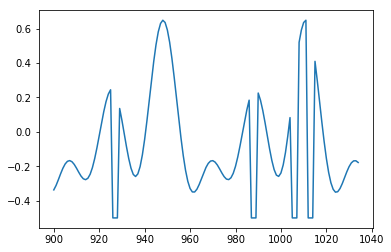

In [2]:
np.random.seed(42)

i = 2000
a1 = np.arange(0,10*i*1,.1)
a2 = np.arange(0,10*i*2,.2)
a3 = np.arange(0,10*i*3,.3)

timeseries = np.cos(a1) + np.sin(a2) + np.sin(a3)
timeseries = (timeseries - timeseries.mean())/(timeseries.max() - timeseries.min())

tmp_idx = np.unique(
    np.int32(
        np.random.uniform(
            0, timeseries.shape[0],
            size=timeseries.shape[0]//20
        )
    )
)
features_idx = np.unique(
    np.hstack(
       [tmp_idx+i for i in range(3)] 
    )
)

df = pd.DataFrame(timeseries, columns=['data'])
df['features'] = 0
df.loc[features_idx, ['features']] = 1

df.loc[features_idx, ['data']] = -.5

plt.plot(df['data'][900:900+135])
print(df.shape)
plt.show()


As our array of samples is a function, we could just use just the function to create batches. But lets pretend we have some fixed-lenght timeseries. It will ease reusing code later if needed

In [3]:
def get_batch(df, batch_size=10, min_source_length=200, max_source_length=400, time_to_predict=65):
    """
    :param df: timeseries data
    :param batch_size: size of the batch
    :param min_source_length: min lenght of the sample
    :param max_source_length: max lenght of the sample
    :param time_to_predict: timeticks we ned to predict
    :return: X [batch_size, len, n_features],
             y_features [batch_size, time_to_predict, n_features-1],
             y [batch_size, time_to_predict]
            where len is random between min_source_length and max_source_length
    """
    df = np.array(df)
    df = df[np.newaxis, :, :]
    source_len = np.int32(
        np.random.uniform(
            min_source_length + time_to_predict,
            max_source_length + time_to_predict,
        )
    )
    start_range = 0
    end_range = df.shape[1] - time_to_predict - source_len
    idxes = np.int32(
        np.random.uniform(
            start_range, end_range,
            size=batch_size
        )
    )

    batch_elem = [np.array(df[:, i:i+source_len, :]) for i in idxes]
    #return batch_elem
    out = np.vstack(batch_elem)
    return out[:, :-time_to_predict, :], out[:, -time_to_predict:, 1:], out[:, -time_to_predict:, 0]

tmp = get_batch(df)
tmp[0].shape, tmp[1].shape, tmp[2].shape

((10, 274, 2), (10, 65, 1), (10, 65))

This will be really basic net without any optimisations or tricks.

In [4]:
def output_layers(dec_output, features):
    concat_tensor = tf.concat([dec_output, features], axis=1)
    
    output = tf.layers.dense(
        concat_tensor,
        concat_tensor.shape[1]*2
    )
    output = tf.layers.dense(
        output,
        10,
    )
    output = tf.layers.dense(
        output,
        1
    )
    return output
    
def decoder(encoder_state, target_features, rnn_size, num_layers_decoder, last_value, time_to_predict):
    """
    :param encoder_state: shape [batch_size, encoder_rnn_depth]
    :param target_features: shape [batch_size, time_to_predict, n_features-1]
    :param last_value: shape [batch_size], last avaliable value
    :return: decoder rnn output
    """
    
    # decoder
    stacked_decoder = []
    for _ in range(num_layers_decoder):
        stacked_decoder.append(
            tf.contrib.rnn.LSTMCell(rnn_size)
        )

    dec_multicell = tf.contrib.rnn.MultiRNNCell(cells=stacked_decoder)
    
    def loop_cond(time, prev_output, prev_decoder_state, array_y):
        return time < time_to_predict
    
    def loop_body(time, prev_output, prev_decoder_state, array_y):
        output, state = dec_multicell(prev_output, prev_decoder_state)
        feature = target_features[:, time, :]
        output = output_layers(output, feature)
        array_y = array_y.write(time, output)
        return time + 1, output, state, array_y
    
    loop_vars = [
        tf.constant(0, dtype=tf.int32),
        last_value,
        encoder_state,
        tf.TensorArray(dtype=tf.float32, size=time_to_predict),
    ]
    y = tf.while_loop(loop_cond, loop_body, loop_vars)[-1]
    y = y.stack()
    y = tf.squeeze(y, axis=-1)
    return tf.transpose(y)

step: 0, loss: 0.1698310673236847
step: 10, loss: 0.11897704005241394
step: 20, loss: 0.09149771928787231
step: 30, loss: 0.07808679342269897
step: 40, loss: 0.07295459508895874
step: 50, loss: 0.07222652435302734
step: 60, loss: 0.07159886509180069
step: 70, loss: 0.06991460919380188
step: 80, loss: 0.06838616728782654
step: 90, loss: 0.061581309884786606
step: 100, loss: 0.05389248579740524


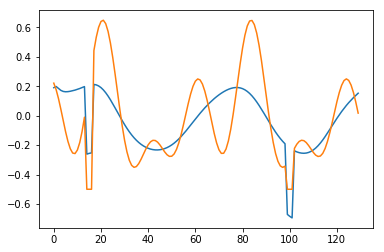

step: 110, loss: 0.04867318645119667
step: 120, loss: 0.04372098296880722
step: 130, loss: 0.04042618349194527
step: 140, loss: 0.03574993833899498
step: 150, loss: 0.03142032027244568
step: 160, loss: 0.02833554707467556
step: 170, loss: 0.02477656863629818
step: 180, loss: 0.022880539298057556
step: 190, loss: 0.02165820822119713
step: 200, loss: 0.020519625395536423


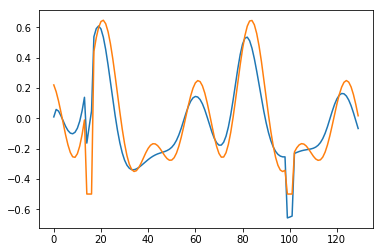

step: 210, loss: 0.020089801400899887
step: 220, loss: 0.017528370022773743
step: 230, loss: 0.017223181203007698
step: 240, loss: 0.016233237460255623
step: 250, loss: 0.015561030246317387
step: 260, loss: 0.015437000431120396
step: 270, loss: 0.015520202927291393
step: 280, loss: 0.014298014342784882
step: 290, loss: 0.013384293764829636
step: 300, loss: 0.014651809819042683


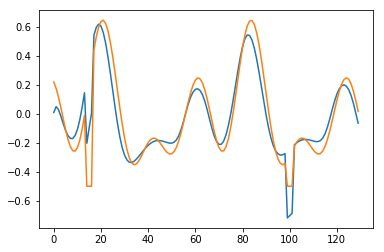

step: 310, loss: 0.013995902612805367
step: 320, loss: 0.012704025022685528
step: 330, loss: 0.012548754923045635
step: 340, loss: 0.013736243359744549
step: 350, loss: 0.01287419255822897
step: 360, loss: 0.013152703642845154
step: 370, loss: 0.013699345290660858
step: 380, loss: 0.01336407195776701
step: 390, loss: 0.012144578620791435
step: 400, loss: 0.013731071725487709


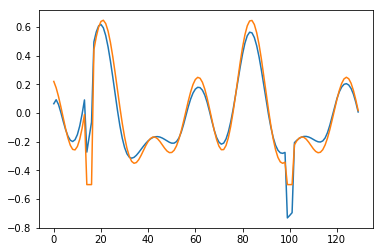

step: 410, loss: 0.012378854677081108
step: 420, loss: 0.012943416833877563
step: 430, loss: 0.012042196467518806
step: 440, loss: 0.012434309348464012
step: 450, loss: 0.011792720295488834
step: 460, loss: 0.012032928876578808
step: 470, loss: 0.012220460921525955
step: 480, loss: 0.012008946388959885
step: 490, loss: 0.011567785404622555
step: 500, loss: 0.012072673998773098


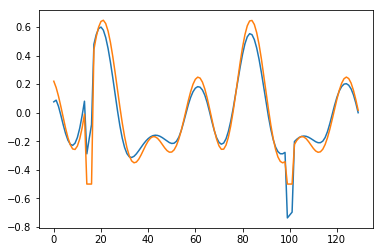

step: 510, loss: 0.011253883130848408
step: 520, loss: 0.011440245434641838
step: 530, loss: 0.011788040399551392
step: 540, loss: 0.01234973594546318
step: 550, loss: 0.011417893692851067
step: 560, loss: 0.011794403195381165
step: 570, loss: 0.011839031241834164
step: 580, loss: 0.012371305376291275
step: 590, loss: 0.01181865856051445
step: 600, loss: 0.011691748164594173


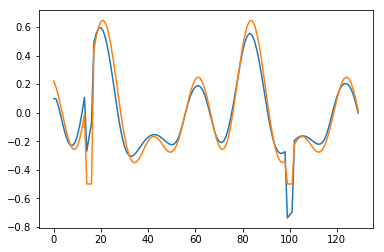

step: 610, loss: 0.011204317212104797
step: 620, loss: 0.012155123054981232
step: 630, loss: 0.010867557488381863
step: 640, loss: 0.011070247739553452
step: 650, loss: 0.011300783604383469
step: 660, loss: 0.01107618398964405
step: 670, loss: 0.011459508910775185
step: 680, loss: 0.011334449052810669
step: 690, loss: 0.011163940653204918
step: 700, loss: 0.011924468912184238


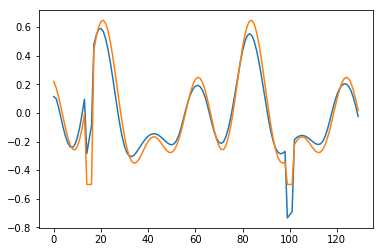

step: 710, loss: 0.011036287993192673
step: 720, loss: 0.01147444173693657
step: 730, loss: 0.0118938609957695
step: 740, loss: 0.012004167772829533
step: 750, loss: 0.01181742176413536
step: 760, loss: 0.011765875853598118
step: 770, loss: 0.011349287815392017
step: 780, loss: 0.011052588932216167
step: 790, loss: 0.010724086314439774
step: 800, loss: 0.011214231140911579


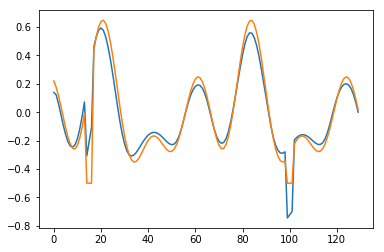

step: 810, loss: 0.011726006865501404
step: 820, loss: 0.011652990244328976
step: 830, loss: 0.011107899248600006
step: 840, loss: 0.01104897353798151
step: 850, loss: 0.011474221013486385
step: 860, loss: 0.011216040700674057
step: 870, loss: 0.010685295797884464
step: 880, loss: 0.010932699777185917
step: 890, loss: 0.011373624205589294
step: 900, loss: 0.011009176261723042


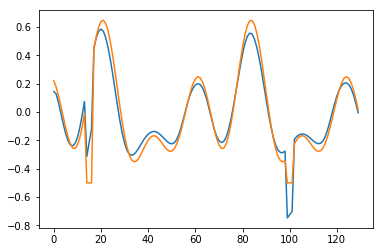

step: 910, loss: 0.011962125077843666
step: 920, loss: 0.010784857906401157
step: 930, loss: 0.010944469831883907
step: 940, loss: 0.010935821570456028
step: 950, loss: 0.011312139220535755
step: 960, loss: 0.010685691609978676
step: 970, loss: 0.011000504717230797
step: 980, loss: 0.010826241225004196
step: 990, loss: 0.011101491749286652
step: 1000, loss: 0.010430454276502132


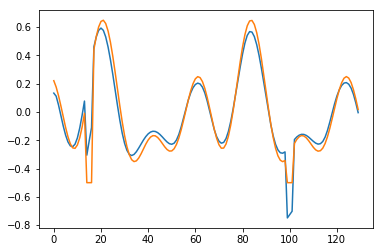

step: 1010, loss: 0.010981450788676739
step: 1020, loss: 0.010039391927421093
step: 1030, loss: 0.011660410091280937
step: 1040, loss: 0.011329393833875656
step: 1050, loss: 0.010433402843773365
step: 1060, loss: 0.011517698876559734
step: 1070, loss: 0.011461623944342136
step: 1080, loss: 0.010269461199641228
step: 1090, loss: 0.011012000031769276
step: 1100, loss: 0.01078153308480978


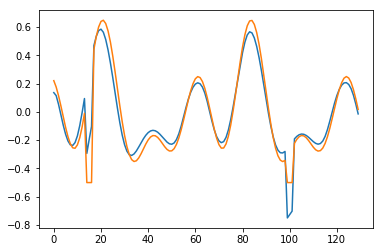

step: 1110, loss: 0.01123776938766241
step: 1120, loss: 0.010043560527265072
step: 1130, loss: 0.010848994366824627
step: 1140, loss: 0.011054646223783493
step: 1150, loss: 0.010618625208735466
step: 1160, loss: 0.009809345938265324
step: 1170, loss: 0.01216497365385294
step: 1180, loss: 0.010652069002389908
step: 1190, loss: 0.010578308254480362
step: 1200, loss: 0.010390074923634529


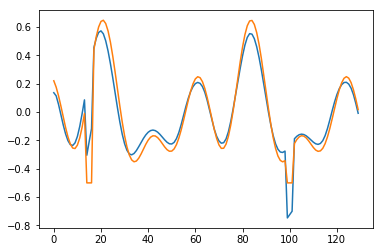

step: 1210, loss: 0.011651363223791122
step: 1220, loss: 0.010854404419660568
step: 1230, loss: 0.01051983330398798
step: 1240, loss: 0.010929969139397144
step: 1250, loss: 0.011084293015301228
step: 1260, loss: 0.010830271989107132
step: 1270, loss: 0.010793490335345268
step: 1280, loss: 0.010398208163678646
step: 1290, loss: 0.010874652303755283
step: 1300, loss: 0.01132394839078188


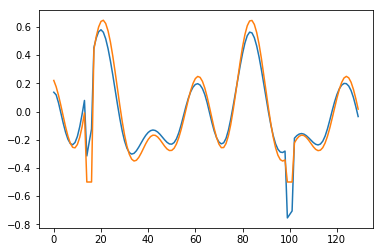

step: 1310, loss: 0.010435076430439949
step: 1320, loss: 0.010134418494999409
step: 1330, loss: 0.010375851765275002
step: 1340, loss: 0.010944051668047905
step: 1350, loss: 0.010037442669272423
step: 1360, loss: 0.010438056662678719
step: 1370, loss: 0.010887160897254944
step: 1380, loss: 0.010400696657598019
step: 1390, loss: 0.010460460558533669
step: 1400, loss: 0.01020592451095581


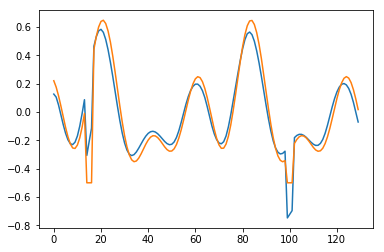

step: 1410, loss: 0.009750477969646454
step: 1420, loss: 0.010656551457941532
step: 1430, loss: 0.010039784014225006
step: 1440, loss: 0.010435006581246853
step: 1450, loss: 0.009831956587731838
step: 1460, loss: 0.01046043075621128
step: 1470, loss: 0.010175456292927265
step: 1480, loss: 0.009879084303975105
step: 1490, loss: 0.010021605528891087
Final prediction


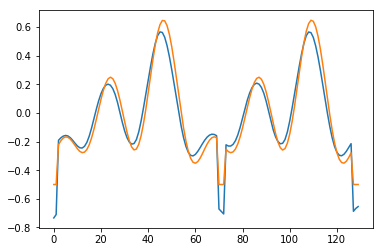

CPU times: user 2h 59min 36s, sys: 17min 48s, total: 3h 17min 25s
Wall time: 37min 48s


In [5]:
%%time

rnn_size=10
num_layers_encoder, num_layers_decoder = 5, 5
min_source_length = 200
max_source_length = 400
batch_size = 200
time_to_predict = 130
steps = 1500

train_graph = tf.Graph()
with train_graph.as_default():
    
    inputs = tf.placeholder(tf.float32, [None, None, 2], name="input")
    target_features = tf.placeholder(tf.float32, [None, time_to_predict, 1], name="target_features")
    targets = tf.placeholder(tf.float32, [None, time_to_predict], name="targets")
    lr = tf.placeholder(tf.float32, name="learning_rate")
    
    sequence_length = tf.placeholder_with_default(
        max_source_length, None, name='sequence_length')

    input_shape = tf.shape(inputs)

    # encoder
    stacked_encoder = []
    for _ in range(num_layers_encoder):
        stacked_encoder.append(
            tf.contrib.rnn.LSTMCell(rnn_size)
        )

    enc_multicell = tf.contrib.rnn.MultiRNNCell(cells=stacked_encoder)

    _, encoder_state = tf.nn.dynamic_rnn(
        enc_multicell,
        inputs,
        sequence_length=sequence_length,
        dtype=tf.float32)
    

    predictions = decoder(
        encoder_state,
        target_features,
        rnn_size,
        num_layers_decoder,
        inputs[:, -1, :1],
        time_to_predict)

    loss = tf.losses.mean_squared_error(labels=targets, predictions=predictions)
    
    optimizer = tf.train.AdamOptimizer()
    
    global_step = tf.Variable(0, name='global_step', trainable=False)
    
    train_op = optimizer.minimize(loss, global_step=global_step)
    
    init = tf.global_variables_initializer()
    
    sess = tf.Session()
    
    summary_writer = tf.summary.FileWriter('./log', sess.graph)
    
    sess.run(init)
    
    X_test = np.array(df.loc[:299, :])
    X_test = X_test[np.newaxis, :, :]
    tmp = np.array(df.loc[299:299+time_to_predict-1])
    y_test_features = tmp[np.newaxis, :, 1:]
    y_test = tmp[np.newaxis, :, 0]
    
    X_val = np.array(df.loc[100:399, :])
    X_val = X_val[np.newaxis, :, :]
    tmp = np.array(df.loc[399:399+time_to_predict-1])
    y_val_features = tmp[np.newaxis, :, 1:]
    y_val = tmp[np.newaxis, :, 0]
    
    for step in range(steps):
        X_b, f_b, y_b = get_batch(
            df, 
            batch_size=batch_size,
            min_source_length=min_source_length,
            max_source_length=max_source_length,
            time_to_predict=time_to_predict)
        
        feed_dict = {
            inputs: X_b,
            target_features: f_b,
            targets: y_b,
        }
        #tmp = sess.run([train_op, loss], feed_dict=feed_dict)
        
        _, loss_value = sess.run([train_op, loss],
                               feed_dict=feed_dict)

        if step % 10 == 0:
            print("step: {}, loss: {}".format(step,loss_value))
            
            
        if (step > 0) and (step % 100 == 0):
            test_preds = sess.run(
                predictions,
                feed_dict={
                    inputs: X_test,
                    target_features: y_test_features
                }
            )
            plt.plot(test_preds[0])
            plt.plot(y_test[0])
            plt.show()
    
    
    val_preds = sess.run(
        predictions,
        feed_dict={
            inputs: X_val,
            target_features: y_val_features
        }
    )

    
print("Final prediction")
plt.plot(val_preds[0])
plt.plot(y_val[0])
plt.show()